In [1]:
import logging
from pathlib import Path
import sys
import data_loading
import utils
import explainers
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import warnings


In [2]:
logging.basicConfig(format='%(asctime)s %(levelname)-7s %(message)s',
                    stream=sys.stderr, level=logging.DEBUG)
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.WARNING)

In [3]:
DATASET_NAME = 'cstr'
WINDOW_SIZE = 10

In [23]:
timeseries, labels, test_timeseries, test_labels = \
        data_loading.get_dataset(DATASET_NAME, binary=False, window_size=WINDOW_SIZE, noise_scale=0.1, use_classes=list(range(0,10)))

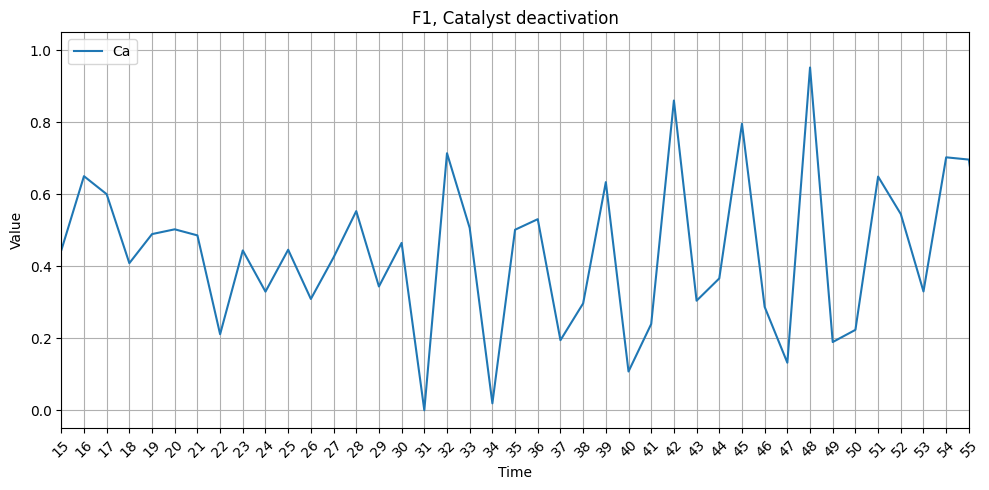

In [24]:
comparison_df=pd.DataFrame(test_timeseries)
comparison_df = comparison_df.groupby(level='node_id').last()
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

for i in range(1,2):
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()
    
    single_node_df_filtered = single_node_df

    columns_to_plot = ['Ca']
    single_node_df_filtered = single_node_df[columns_to_plot]    

    scaler = MinMaxScaler()
    single_node_df_filtered = pd.DataFrame(scaler.fit_transform(single_node_df_filtered), columns=single_node_df_filtered.columns, index=single_node_df_filtered.index)    
    
    # print(single_node_df_filtered)

    single_node_df_filtered.plot(figsize=(10, 5))
    
    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Value')
    plt.grid(True)
    plt.legend(loc='upper left')
    # plt.ticklabel_format(style='sci', axis='y', scilimits=(100,200))
    # plt.yticks(np.arange(0, 500, step=10))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df_filtered), step=1), rotation=45)
    plt.xlim(single_node_df_filtered.index[5], single_node_df_filtered.index[45])
    plt.tight_layout()
    plt.show()


In [25]:
# print(timeseries.head)
# print(labels.head)
# print(test_timeseries.head)
# print(labels['label'])

In [26]:
extractor = utils.TSFeatureGenerator(threads=1, trim=0)
pipeline = Pipeline([
    ('assert1', utils.CheckFeatures()),
    ('features', utils.TSFeatureGenerator(threads=1, trim=0)),
    ('assert2', utils.CheckFeatures()),
    ('scaler', MinMaxScaler(feature_range=(-1, 1))),
    ('clf', RandomForestClassifier(n_estimators=100))
], verbose=True)

In [27]:
c = RandomForestClassifier()
print(help(c))

Help on RandomForestClassifier in module sklearn.ensemble._forest object:

class RandomForestClassifier(ForestClassifier)
 |  RandomForestClassifier(n_estimators=100, *, criterion='gini', max_depth=None, min_samples_split=2, min_samples_leaf=1, min_weight_fraction_leaf=0.0, max_features='sqrt', max_leaf_nodes=None, min_impurity_decrease=0.0, bootstrap=True, oob_score=False, n_jobs=None, random_state=None, verbose=0, warm_start=False, class_weight=None, ccp_alpha=0.0, max_samples=None, monotonic_cst=None)
 |  
 |  A random forest classifier.
 |  
 |  A random forest is a meta estimator that fits a number of decision tree
 |  classifiers on various sub-samples of the dataset and uses averaging to
 |  improve the predictive accuracy and control over-fitting.
 |  Trees in the forest use the best split strategy, i.e. equivalent to passing
 |  `splitter="best"` to the underlying :class:`~sklearn.tree.DecisionTreeRegressor`.
 |  The sub-sample size is controlled with the `max_samples` paramet

In [28]:
pipeline.fit(timeseries, labels)

[Pipeline] ........... (step 1 of 5) Processing assert1, total=   0.0s
[Pipeline] .......... (step 2 of 5) Processing features, total=   8.5s
[Pipeline] ........... (step 3 of 5) Processing assert2, total=   0.0s
[Pipeline] ............ (step 4 of 5) Processing scaler, total=   0.0s


/Users/omkar/anaconda3/envs/comte1/lib/python3.9/site-packages/sklearn/base.py:1351: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


[Pipeline] ............... (step 5 of 5) Processing clf, total=   0.4s


Pipeline(steps=[('assert1', CheckFeatures()),
                ('features', TSFeatureGenerator(threads=1, trim=0)),
                ('assert2', CheckFeatures()),
                ('scaler', MinMaxScaler(feature_range=(-1, 1))),
                ('clf', RandomForestClassifier())],
         verbose=True)

In [29]:
test_timeseries

Caf         h          Qf        Ca           T  \
node_id   timestamp                                                         
node_1_10 1          1.168702  6.458806  101.287410  0.032619  402.762802   
          2          0.981248  5.446470  105.083926  0.034636  358.489021   
          3          1.002086  6.713919   99.202966  0.043652  383.903193   
          4          1.073092  5.992581   94.669451  0.039120  481.553214   
          5          0.997048  5.516507   78.933678  0.032746  430.754318   
...                       ...       ...         ...       ...         ...   
node_9_99 95         0.860979  4.985654  111.748374  0.060485  368.896644   
          96         1.015794  7.297553   99.660806  0.049717  421.660026   
          97         1.094990  6.028433   94.406721  0.055319  373.876261   
          98         0.951880  6.252490   97.557620  0.062245  468.706551   
          99         0.927221  5.305029   93.750523  0.056461  390.118323   

                             Tf          Tc         Qc         Tcf           Q  
node_id   timestamp                                                             
node_1_10 1          323.533288  388.882193  14.424198  316.871976   99.645128  
          2          277.135675  266.504849  14.265413  339.284407  100.790177  
          3          304.258339  346.422637  14.431009  346.033699  119.419547  
          4          273.445738  311.966779  14.759272  286.758866  101.051597  
          5          352.182743  370.422913  15.867485  281.246052  109.953848  
...                         ...         ...        ...         ...         ...  
node_9_99 95         269.001023  277.267398  19.828897  306.411256   91.033141  
          96         256.223829  357.529838  17.097787  316.652915  107.995436  
          97         298.240749  326.226963  18.905601  338.100434  100.365700  
          98         305.334181  295.805685  19.598807  332.195548  100.002484  
          99         335.389595  378.196090  22.244393  258.298005  109.181808  

[8100 rows x 10 columns]

In [30]:
preds = pipeline.predict(test_timeseries)

In [31]:
print("F1 score:", f1_score(test_labels, preds, average='weighted'))
for label, i in zip(np.unique(test_labels), f1_score(test_labels, preds, labels=np.unique(test_labels), average=None)):
    print(label, i)

F1 score: 0.6038737725917183
0 0.6653306613226453
1 0.8095238095238095
2 0.0
3 0.43636363636363634
4 0.5324675324675324
5 0.453125
6 0.39622641509433965
7 0.9701492537313433
8 0.796875
9 0.8717948717948718


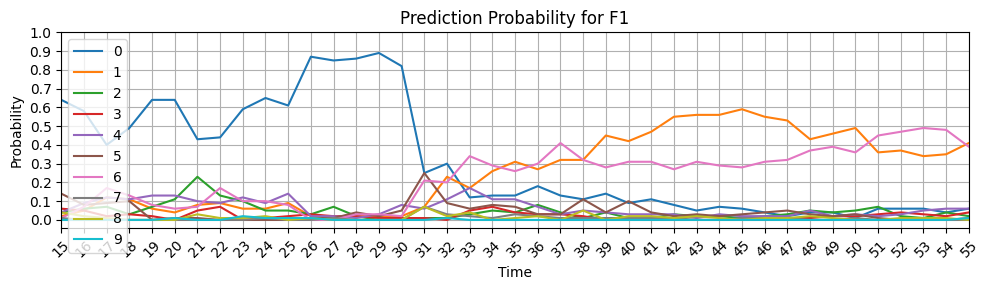

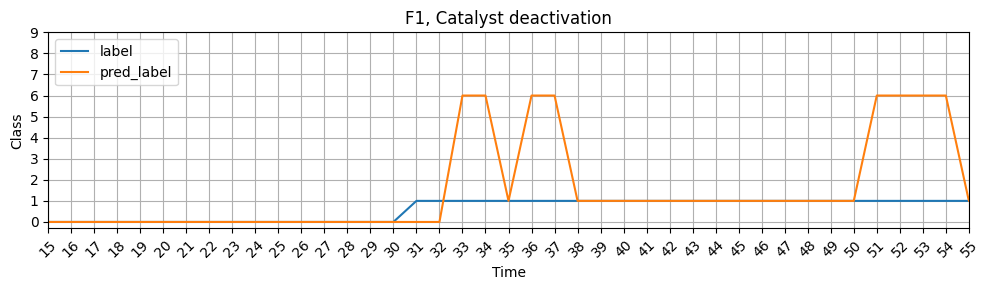

In [32]:
comparison_df=pd.DataFrame(test_labels)
comparison_df['pred_label'] = preds
comparison_df['ind_node'] = ([int(element.split('_')[1]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df['ind_time'] = ([int(element.split('_')[2]) for element in comparison_df.index.get_level_values('node_id')])
comparison_df.set_index(['ind_node', 'ind_time'], inplace=True)
label_dict = {'1': 'F1, Catalyst deactivation', '2': 'F2, Heat-exchanger fouling', '3': 'F3, Dead-coolant flow measurement', '4': 'F4, Bias in reactor temperature measurement', '5': 'F5, Coolant valve stiction qF7', '6': 'F6, Step change in QF', '7': 'F7, Ramp change in CAF', '8': 'F8, Ramp change in TF', '9': 'F9, Ramp change in TCF', '0': 'N, Normal operation'}

warnings.filterwarnings("ignore")

for i in range(1,2):
    # print(comparison_df)
    single_node_df = comparison_df.loc[comparison_df.index.get_level_values('ind_node') == i]
    single_node_df = single_node_df.reset_index(level='ind_node', drop=True)
    single_node_df = single_node_df.sort_index()

    # print(single_node_df)
    # plt.figure(figsize=(20, 2))


# Plot prediction probability
    pred_ar = []
    for j in range(WINDOW_SIZE,100):
        loca = "node_{}_{}".format(i,j)
        predi = pipeline.predict_proba(test_timeseries.loc[[loca], :, :])
        pred_ar.append(predi[0])
    pred_df = pd.DataFrame(pred_ar, index=range(WINDOW_SIZE,100))
    # print(pred_df)

    pred_df.plot(figsize=(10, 3))
    plt.title("Prediction Probability for F{}".format(i))
    plt.xlabel('Time')
    plt.ylabel('Probability')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()


    single_node_df.plot(figsize=(10, 3))

    plt.title(label_dict[str(i)])
    plt.xlabel('Time')
    plt.ylabel('Class')
    plt.grid(True)
    plt.legend(loc='upper left')
    plt.yticks(np.arange(0, 10, step=1))
    plt.xticks(np.arange(WINDOW_SIZE, len(single_node_df), step=1), rotation=45)
    plt.xlim(single_node_df.index[5], single_node_df.index[45])
    plt.tight_layout()
    plt.show()

warnings.resetwarnings()


In [33]:
comte = explainers.BruteForceSearch(pipeline, timeseries, labels, silent=False, threads=1,num_distractors=2)

In [34]:
# test_labels['label']

In [35]:
### TEST CASE 1
### True: 2 All clear, Predicted: 3 Not clear

true_select = 1 #UPDATE HERE FOR OTHER CLASSES
pred_select = 0 #UPDATE HERE FOR OTHER CLASSES
# print(test_labels['label'].values)
# print(preds)
indices_test = []
for idx, (true, pred, node_id) in enumerate(zip(test_labels['label'].values, preds, test_labels['label'].index.get_level_values('node_id'))):
    # if(true!=pred):
    #     print(idx,true,pred)
    if true ==  true_select and pred == pred_select:
        indices_test.append([node_id,idx])
print(indices_test)


[['node_1_31', 21], ['node_1_32', 22], ['node_1_60', 50], ['node_1_61', 51], ['node_1_65', 55], ['node_1_66', 56], ['node_1_67', 57]]


In [36]:
# pipeline.predict_proba(test_timeseries.loc[['node_6_32'], :, :])

2024-03-07 10:32:33,096 INFO    Working on turning label from 0 to 1
2024-03-07 10:32:33,098 INFO    Returning distractors ['node_1_71', 'node_1_81']
2024-03-07 10:32:33,098 INFO    Trying distractor 1 / 2
2024-03-07 10:32:33,114 INFO    Current probas: [[0.3  0.23 0.01 0.   0.11 0.09 0.2  0.03 0.02 0.01]]
2024-03-07 10:32:33,262 INFO    Best column: Ca, best case: 0.49
2024-03-07 10:32:33,287 INFO    Current probas: [[0.15 0.49 0.06 0.   0.08 0.05 0.17 0.   0.   0.  ]]
2024-03-07 10:32:33,288 INFO    Trying distractor 2 / 2
2024-03-07 10:32:33,303 INFO    Current probas: [[0.3  0.23 0.01 0.   0.11 0.09 0.2  0.03 0.02 0.01]]
2024-03-07 10:32:33,450 INFO    Best column: Ca, best case: 0.47
2024-03-07 10:32:33,476 INFO    Current probas: [[0.09 0.47 0.02 0.02 0.08 0.06 0.25 0.   0.01 0.  ]]


###########
['Ca']
###########


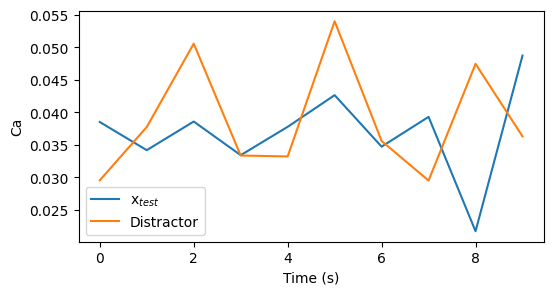

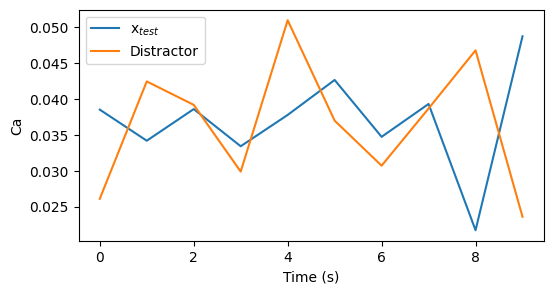

In [38]:
warnings.filterwarnings("ignore")

x_test = test_timeseries.loc[['node_1_32'], :, :]
explanation = comte.explain(x_test,to_maximize=true_select,savefig=False) 
print('###########') 
print(explanation)
print('###########')

warnings.resetwarnings()